In [1]:
# All imports

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd

import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K
import torch.nn.functional as F

import timeit
import random

Using TensorFlow backend.


In [0]:
# GPU support
use_cuda = True

#Loading the dataset

11493376/11490434 [==============================] - 2s 0us/step
The handwritten number is  0


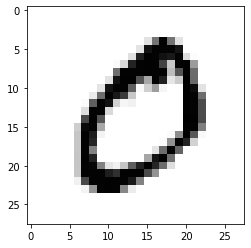

In [3]:
# loading the MNIST dataset, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# To print the image of the written number along with the value in the y column
image_index = 1                 # You may select anything up to y_train.shape[0]

plt.imshow(x_train[image_index], cmap='Greys')
print("The handwritten number is ", y_train[image_index])

#Preprocessing the Dataset

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Ensuring the datatype is float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing RGB codes by dividing by the max RGB value.
x_train /= 255
x_test /= 255

y_train.reshape(y_train.shape[0],1)
y_test.reshape(y_test.shape[0],1)

# Converting to categorical values, one hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# print('x_train shape:', x_train.shape)
# print('Number of images in x_train', x_train.shape[0])
# print('Number of images in x_test', x_test.shape[0])

In [0]:
# Converting training and test sets to tensor from numpy
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [0]:
# Creating training set
training_size = 256

In [0]:
# Creating test set
test_size = 256

#Creating the Neural Network Architecture

In [0]:
# Function for randomising the chosen rows weights for controlled dropout
def controlled_drop(n):
  return (random.randint(0,2000 - n))

In [0]:
# CREATING NN ARCHITECTURE 784-2000-2000-10

class myNN(nn.Module):
  def __init__(self):
    super(myNN, self).__init__()    
    self.weights1 = nn.Parameter(torch.randn(784,2000)*0.1)     # Declaring 'weights' layerwise for each neuron in the neural network
    self.weights2 = nn.Parameter(torch.randn(2000,2000)*0.1)
    self.weights3 = nn.Parameter(torch.randn(2000,10)*0.1)
    self.bias1 = nn.Parameter(torch.randn(1,2000))              # Declaring 'biases' layerwise for each neuron in the neural network 
    self.bias2 = nn.Parameter(torch.randn(1,2000))
    self.bias3 = nn.Parameter(torch.randn(1,10))

    self.bias1.requires_grad_()                                 # Including biases in the gradient calculation for backprop
    self.bias2.requires_grad_()
    self.bias3.requires_grad_()

    self.weights1.requires_grad_()                              # Including weights in the gradient calculation for backprop
    self.weights2.requires_grad_()
    self.weights3.requires_grad_()

  def forward(self, X_train,dp):
      h1 = torch.matmul(X_train,self.weights1 ) + self.bias1                                                      # Calculating the 'WX + b' for hidden layer 1 
      a1 = h1.relu()                                                                                              # ReLU activation on hidden layer 1
      
      drop1 = controlled_drop(dp)                                                                                 # Finding a random initial index for dropout
      # a1 /= (dp/2000)       # Adjusting the output reduction due to dropout not required this way since we directly adjust it in h2 itself 
      h2 = (torch.matmul( a1[:,drop1:drop1 + dp] , self.weights2[drop1:drop1+dp,:]  ) *(2000/dp)) + self.bias2    # Calculating the 'WX + b' for hidden layer 2 with dropout for layer 1 applied
      a2 = h2.relu()                                                                                              # ReLU activation on hidden layer 2
      
      drop2 = controlled_drop(dp)                                                                                 # Finding a random initial index for dropout
      # a2 /= (dp/2000)       # Adjusting the output reduction due to dropout not required this way
      h3 = (torch.matmul( a2[:,drop2:drop2 + dp] , self.weights3[drop2: drop2+dp,:]  ) *(2000/dp)) + self.bias3   # Calculating the 'WX + b' for output layer with dropout for layer 2 applied
      return h3
   

Forward Propagation

In [0]:
def training_drop(myXtrain, myYtrain, firstNN, epochs, opti, criterion): 
  x_plt_points = []
  y_plt_points = []
  y_plt_acc = []

  # Training the model for epochs number of weight updates
  for epoch in range(epochs):
      
    start_index = (epoch*training_size)%25600                 # Test set size is 25600
    myXtrain = x_train[start_index :start_index + training_size, :].reshape(training_size,784)
    myYtrain = y_train[start_index :start_index + training_size, :].reshape(training_size,10)

    y_out = firstNN(myXtrain,1000)                            # Dropout for 50% applied
    lossNN = criterion(y_out, torch.max(myYtrain, 1)[1]) # No doubling because the adjustment has been taken care of in the expression after dropout itself
    opti.zero_grad()
    lossNN.backward()                                         # Back Prop done for variables with require_grad
    opti.step()                                               # Weight update done

    if epoch%250 == 0:                                        # Evaluating the model after every 250 weight updates on the MNIST test set
      myXtest = x_test[0:test_size, :].reshape(test_size, 784)
      myYtest = y_test[0:test_size, :].reshape(test_size, 10)
    
      y_outtest = firstNN(myXtest,2000)                       # Forward prop on test set followed by loss calculation
      lossNNtest = criterion(y_outtest, torch.max(myYtest, 1)[1])

      correct_test = torch.eq(torch.max(y_outtest, 1)[1], torch.max(myYtest, 1)[1]).sum()
      print("Epoch : ", epoch, "Loss : ", lossNNtest.item(), ", Test Set error : ", 1 - correct_test.item()/ test_size, ", Test accuracy is : ", 100 * correct_test.item()/ test_size )

      x_plt_points.append(epoch)                              # Saving test_error along with the corresponding iteration_gonumber to plot the graph
      y_plt_points.append(lossNNtest.item())
      y_plt_acc.append(1 - correct_test.item()/ test_size)


  plt.plot(x_plt_points, y_plt_acc, color='green', linewidth = 1)
  plt.ylim(0,0.15) 
  plt.xlim(0,epochs) 
    
  # Naming the axes 
  plt.xlabel('Number of iterations')  
  plt.ylabel('Test error') 
    
  # Giving a title to the graph 
  plt.title('Test Set') 
    
  # Displaying the plot 
  plt.show()
   
  


#Creating a Neural Network

In [0]:
firstNN = myNN()

In [0]:
# Defining the conditionalities for training 
criterion = nn.CrossEntropyLoss()
opti = optim.Adam(firstNN.parameters(), lr = 0.00005, betas=(0.9,0.999), eps=1e-07, amsgrad=False )

In [0]:
# Enabling GPU support for forward and backprop
device = torch.device("cuda")

x_train = x_train.to(device)
y_train = y_train.to(device)
firstNN = firstNN.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

Training the model

Epoch :  0 Loss :  23.363033294677734 , Test Set error :  0.9140625 , Test accuracy is :  8.59375
Epoch :  250 Loss :  3.2620954513549805 , Test Set error :  0.40234375 , Test accuracy is :  59.765625
Epoch :  500 Loss :  1.6530513763427734 , Test Set error :  0.24609375 , Test accuracy is :  75.390625
Epoch :  750 Loss :  1.1604715585708618 , Test Set error :  0.16796875 , Test accuracy is :  83.203125
Epoch :  1000 Loss :  1.0558435916900635 , Test Set error :  0.16015625 , Test accuracy is :  83.984375
Epoch :  1250 Loss :  0.8112967610359192 , Test Set error :  0.1328125 , Test accuracy is :  86.71875
Epoch :  1500 Loss :  0.789681077003479 , Test Set error :  0.1328125 , Test accuracy is :  86.71875
Epoch :  1750 Loss :  0.6843985319137573 , Test Set error :  0.12890625 , Test accuracy is :  87.109375
Epoch :  2000 Loss :  0.5252882242202759 , Test Set error :  0.10546875 , Test accuracy is :  89.453125
Epoch :  2250 Loss :  0.4657825827598572 , Test Set error :  0.0859375 , Test 

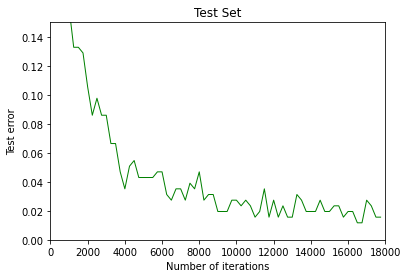

Total time taken is :  70.38300689


In [14]:
# Start training the model
epochs= 18000
start = timeit.default_timer()

training_drop(x_train, y_train, firstNN, epochs, opti, criterion)

end = timeit.default_timer()
print("Total time taken is : ", end - start)

In [15]:
# Training accuracy

postout = firstNN(x_train[:training_size, :].reshape(training_size,784),2000)

correct = torch.eq(torch.max(postout, 1)[1], torch.max(y_train[0:training_size, :].reshape(training_size,10), 1)[1]).sum()
print(correct)
print("Training accuracy is : ", 100 * correct.item()/ training_size )

tensor(255, device='cuda:0')
Training accuracy is :  99.609375


In [16]:
# Testing accuracy

myXtest = x_test[0:10*test_size, :].reshape(10*test_size, 784)
myYtest = y_test[0:10*test_size, :].reshape(10*test_size, 10)


y_outtest = firstNN(myXtest,2000)
lossNNtest = criterion(y_outtest, torch.max(myYtest, 1)[1])

correct_test = torch.eq(torch.max(y_outtest, 1)[1], torch.max(myYtest, 1)[1]).sum()
print("Total number of predictions", myXtest.shape[0])
print("Total number of correct predictions : ", correct_test.item(), "\nTest accuracy is : ", 100 * correct_test.item()/ (10*test_size) )


Total number of predictions 2560
Total number of correct predictions :  2436 
Test accuracy is :  95.15625
